In [7]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt

In [8]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages, fixing_releases
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages, count(distinct advisory_id, version) as fixing_releases
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by advisories desc;'''
df = pd.DataFrame(sql.execute(q))

In [9]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Maven,1322,1082,651,1876
1,Composer,855,599,228,1733
2,npm,792,474,540,949
3,pip,557,398,261,820
4,NuGet,258,230,55,285
5,Go,235,190,183,325
6,RubyGems,219,167,119,362


In [10]:
df.loc[len(df)]=['Total',df['advisories'].sum(),df['advisory_with_CVEs'].sum(),df['packages'].sum(), df['fixing_releases'].sum()] 
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Maven,1322,1082,651,1876
1,Composer,855,599,228,1733
2,npm,792,474,540,949
3,pip,557,398,261,820
4,NuGet,258,230,55,285
5,Go,235,190,183,325
6,RubyGems,219,167,119,362
7,Total,4238,3140,2037,6350


In [11]:
df['non-CVEs (%)'] = df['advisories'] - df['advisory_with_CVEs']
df['non-CVEs (%)'] = round (df['non-CVEs (%)'] / df['advisories'] * 100 , 2)
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,non-CVEs (%)
0,Maven,1322,1082,651,1876,18.15
1,Composer,855,599,228,1733,29.94
2,npm,792,474,540,949,40.15
3,pip,557,398,261,820,28.55
4,NuGet,258,230,55,285,10.85
5,Go,235,190,183,325,19.15
6,RubyGems,219,167,119,362,23.74
7,Total,4238,3140,2037,6350,25.91


In [12]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrr}
\hline
 ecosystem   &   advisories &   advisory\_with\_CVEs &   packages &   fixing\_releases &   non-CVEs (\%) \\
\hline
 Maven       &         1322 &                 1082 &        651 &              1876 &          18.15 \\
 Composer    &          855 &                  599 &        228 &              1733 &          29.94 \\
 npm         &          792 &                  474 &        540 &               949 &          40.15 \\
 pip         &          557 &                  398 &        261 &               820 &          28.55 \\
 NuGet       &          258 &                  230 &         55 &               285 &          10.85 \\
 Go          &          235 &                  190 &        183 &               325 &          19.15 \\
 RubyGems    &          219 &                  167 &        119 &               362 &          23.74 \\
 Total       &         4238 &                 3140 &       2037 &              6350 &          25.91 \\
\hline
\end{tabular}


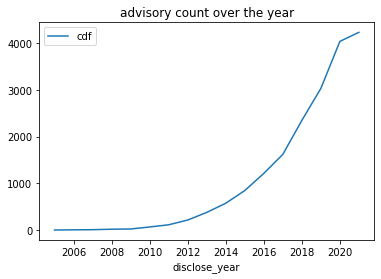

In [31]:
q= '''select year(a.disclose_date) as disclose_year, count(distinct a.id) as count
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by year(a.disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cdf']=df['count'].cumsum()
fig = df.plot(x='disclose_year',y='cdf',kind='line', title = 'advisory count over the year').get_figure()

In [32]:
fig.savefig('cdf_disclose.png')


In [33]:
df

,disclose_year,count,cdf
0,2005,1,1
1,2006,4,5
2,2007,3,8
3,2008,10,18
4,2009,5,23
5,2010,43,66
6,2011,47,113
7,2012,102,215
8,2013,163,378
9,2014,197,575


In [36]:
(4238-847) / 4238

0.8001415762151959